In [69]:
#%pylab inline
#%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib
import gwsurrogate
import numpy as np
import scri
import h5py
from astropy import constants as const
from scipy.interpolate import CubicSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from pycbc.detector import Detector
from gwpy.timeseries import TimeSeries
from gwpy.detector import Channel
import os
from shutil import copyfile
import fileinput
import seaborn as sns
import math
from math import pi
## if you need the surrogate data: 
##gwsurrogate.catalog.pull('NRSur7dq4')

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

### Helper functions

In [70]:
## Helper functions
def Ramp(time, t_s, t_r):
    """ Ramp function for tapering the waveform"""
    if (time < t_s):
        return 0.0
    elif time > (t_s + t_r):
        return 1.0
    else:
        t = (time - t_s)/t_r
        return t**5*(126 + t*(-420 + t*(540 + t*(-315 + 70*t))))
    
def swsh(s, modes, theta, phi, psi=0):
    """
    Return a value of a spin-weighted spherical harmonic of spin-weight s. 
    If passed a list of several modes, then a numpy array is returned with 
    SWSH values of each mode for the given point.
    For one mode:       swsh(s,[(l,m)],theta,phi,psi=0)
    For several modes:  swsh(s,[(l1,m1),(l2,m2),(l3,m3),...],theta,phi,psi=0)
    """
    import spherical_functions as sf
    import quaternion as qt
    return sf.SWSH(qt.from_spherical_coords(theta, phi), s, modes) * np.exp(1j * s * psi)

def GetPeakTime(time, data): 
    """ Grab the peak time of some data """
    t_peak = time[np.argmax(data)]
    return t_peak

def SubtractPeakTime(time, data): 
    """ Subtract the peak time of some data """
    t_peak = GetPeakTime(time, data)
    return time - t_peak

def dt_eval(time):
    """ Return the time step of a given time array """
    return (time[1] - time[0])

### Extrapolate the waveforms that we're interested in

In [43]:
# ## Extrapolate the waveforms
# scri.extrapolate(
#     InputDirectory = 'Waveforms/Lev1',
#     OutputDirectory = 'Waveforms/Lev1',
#     DataFile = 'rh_FiniteRadii_CodeUnits.h5',
#     ChMass = 1.000044463203, 
#     UseStupidNRARFormat = True, 
# )
# scri.extrapolate(
#     InputDirectory = 'Waveforms/Lev2',
#     OutputDirectory = 'Waveforms/Lev2',
#     DataFile = 'rh_FiniteRadii_CodeUnits.h5',
#     ChMass = 1.0000147234369998, 
#     UseStupidNRARFormat = True, 
# )
# scri.extrapolate(
#     InputDirectory = 'Waveforms/Lev3',
#     OutputDirectory = 'Waveforms/Lev3',
#     DataFile = 'rh_FiniteRadii_CodeUnits.h5',
#     ChMass = 1.000000289914, 
#     UseStupidNRARFormat = True, 
# )

### Read in the extrapolated waveforms

In [43]:
## Read in the extrapolated modes
def ReadExtrapolatedModes(file, mass_msun, dist_kpc, theta, phi, dt, interpolate = True):
    """ 
        File is the file containing the extrapolated waveform that we want to read in 
        mass_msun is the total mass of the system in solar masses, and 
        dist_kpc is the distance to the system in kpc. 
        theta and phi are angles determining the inclination.
        dt is the timestep (reciprocal of the sampling rate)
        
        If we want to interpolate the waveform to have even timesteps dt, then 
        set interpolate to True. Otherwise, we'll return the data without 
        performing the interpolation """

    ## Read in the data
    f = h5py.File(file, 'r')
    
    ## grab the length of the waveform first
    data = f['Extrapolated_N2.dir']['Y_l2_m2.dat']
    time = np.array(data[:,0])
    
    h_plus = np.zeros(len(time))
    h_cross = np.zeros(len(time))

    #modes = [(2, -2), (2,2)]
    modes = [(l,m) for l in range(2,5) for m in range(-l, l+1)]
    for mode in modes: 
        
        ## Grab the mode in question
        #print('Computing for ', mode)
        l = mode[0]
        m = mode[1]
        
        data = f['Extrapolated_N2.dir']['Y_l' + str(l) + '_m' + str(m) + '.dat']
        real = np.array(data[:,1])
        imag = np.array(data[:,2])
        coeff = real + 1j * imag
        
        ## Multiply by the corresponding spin-weighted spherical harmonic
        Ylm = swsh(-2, [(l,m)], theta=theta, phi=phi, psi=0) 
        h = coeff * Ylm 
        
        ## Add to our h_plus and h_cross computations
        h_plus = h_plus + np.real(h)
        h_cross = h_cross - np.imag(h) 
        
        
    ## Apply the astrophysical parameters
    time = time*mass_msun*const.G/(const.c**3)
    h_plus = h_plus*const.G*mass_msun/((const.c)**2*dist_kpc)
    h_cross = h_cross*const.G*mass_msun/((const.c)**2*dist_kpc)

    ## Taper the waveform and apply the ramp (need to start the waveform at zero for this)
    time = time - time[0]
    ramp = np.array([Ramp(t.value, 0.1, 0.3) for t in time])
    
    h_plus = h_plus * ramp
    h_cross = h_cross * ramp
    
    ## Now subtract off the peak time (this makes the spine interpolation easier)
    amp = np.sqrt(h_plus**2 + h_cross**2)
    time = time - time[np.argmax(amp)]
    
    if not interpolate:
        print("Not performing the interpolation")
        return time, h_plus, h_cross
    
    ## Now build the interpolants 
    cs_plus = InterpolatedUnivariateSpline(time, h_plus)
    cs_cross = InterpolatedUnivariateSpline(time, h_cross)

    ## Now create an evenly-spaced time array and interpolate the data 
    time_cs = np.arange(time[0].value, time[-1].value, dt)

    h_plus_cs = cs_plus(time_cs) 
    h_cross_cs = cs_cross(time_cs) 
    
    ## Return these new interpolated values
    return time_cs, h_plus_cs, h_cross_cs, np.sqrt(h_plus_cs**2 + h_cross_cs**2)
    

### Evaluate the surrogate

In [71]:
## Load in the surrogate
sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_sur

Loaded NRSur7dq4 model


In [72]:
## Surrogate evaluation
def EvaluateSurrogate(q, chiA, chiB, mass, dist_mpc, f_low, theta, phi, dt, surrogate_projection=True):
    """ Evaluate the surrogate waveform 
        If surrogate_projection is true, then use the native surrogate inclination calculation routine
        Otherwise combine ourselves using SWSH"""
    
    if (surrogate_projection):
        ## Use the native surrogate inclination computation
        
        print('the distance is', dist_mpc)
        data = sur(q, chiA, chiB, dt = dt, units = 'mks', M = mass, dist_mpc = dist_mpc, f_low = f_low, \
               inclination = theta, ellMax = 4, phi_ref = pi/2 - phi)
    
        """ Surrogate documentation: If inclination/phi_ref are specified, the complex strain (h =
                 hplus -i hcross) evaluated at (inclination, pi/2 - phi_ref) on
                 the sky of the reference frame is returned.
                 CHANGE THIS for different values of phi """
        time = data[0]
        h_plus = np.real(data[1])
        h_cross = -1 * np.imag(data[1])
        
        time = time - time[0]
        ramp = np.array([Ramp(t, 0.27, 0.3) for t in time])
    
        h_plus = h_plus * ramp
        h_cross = h_cross * ramp
    
        ## Now subtract off the peak time (this makes the spine interpolation easier)
        amp = np.sqrt(h_plus**2 + h_cross**2)
        time = time - time[np.argmax(amp)]
    
        ## Ramp the surrogate
        
        return time, h_plus, h_cross, np.sqrt(h_plus**2 + h_cross**2)
        
    else:
        ## Compute the inclination ourselves
        """ Dictionary of modes is returned """
        print('not here')
        modes = sur(q, chiA, chiB, dt = dt, units = 'mks', M = mass, dist_mpc = dist_mpc, f_low = f_low)
        time = modes[0]
    
        h_plus = np.zeros(len(time))
        h_cross = np.zeros(len(time))
        
        eval_modes = [(2, -2), (2, -1), (2, 0), (2, 1), (2,2)]
    
        for mode in eval_modes: 
        
            ## Grab the mode in question
            l = mode[0]
            m = mode[1]
            h_coeff = modes[1][(mode[0], mode[1])]
            print(h_coeff)
        
            ## Multiply by the corresponding spin-weighted spherical harmonic
            Ylm = swsh(-2, [(l,m)], theta=theta, phi=phi, psi=0) 
            h = h_coeff * Ylm 
        
            ## Add to our h_plus and h_cross computations
            h_plus = h_plus + np.real(h)
            h_cross = h_cross - np.imag(h) 

        return time, h_plus, h_cross, 
        

### Pad the data in time and project to detectors

In [73]:
## Time padding and projection to detectors
def ProjectToDetectors(ra, dec, pol, t0, plus, cross, time):
    '''
    ra - Right Ascension
    dec - Declination
    pol - Polarization Angle
    t0 - reference time for when signal reaches Hanford
    '''
    
    ## Grab the dt
    dt = dt_eval(time)
    
    d_H1 = Detector("H1")
    d_L1 = Detector("L1")
    
    # The time delay of the signal between the detectors
    t_delay = d_L1.time_delay_from_detector(d_H1, ra, dec, t0)
    
    # Round the delay time to the nearest dt (this assumes that t_gps is a multiple of dt)
    t_delay_rounded = round(t_delay / dt) * dt
    print("True delay time: ", t_delay, " Nearest multuple of dt: ", t_delay_rounded, " dt: ", dt)
    
    #Antenna Patterns
    Fp_H1, Fc_H1 = d_H1.antenna_pattern(ra, dec, pol, t0)
    Fp_L1, Fc_L1 = d_L1.antenna_pattern(ra, dec, pol, t0 + t_delay_rounded)
    
    #project
    h_H1 = Fp_H1*plus + Fc_H1*cross
    h_L1 = Fp_L1*plus + Fc_L1*cross
    
    #Shift times
    time_H1 = time
    time_L1 = time + t_delay_rounded
    
    return h_H1, h_L1, time_H1, time_L1

def PadZeroes(time, strain, t_gps, peak_time_in_segment, segment_length):

    ## Now to pad the data with zeros -- we want to pad both the H1 and L1 data so that 
    ## they span the same gps times
    segment_start_time = t_gps - peak_time_in_segment
    segment_end_time = segment_start_time + segment_length
    
    print("Segment start: ", segment_start_time, " Segment end: ", segment_end_time)
    
    ## Do Hanford first (see how much we need to pad in order to get )
    start_pad_time = time[0] - segment_start_time
    end_pad_time = segment_end_time - time[-1]
    
    ## Figure out how many integer zeroes to pad the data
    start_pad_zeros = start_pad_time / dt
    end_pad_zeros = end_pad_time / dt
    
    print("Start pad: ", start_pad_zeros, " End pad: ", end_pad_zeros)
    
    ## Pad the data with zeroes 
    strain_padded = np.pad(strain, (int(start_pad_zeros), int(end_pad_zeros)), 'constant', constant_values=(0.0, 0.0))
    time_padded = np.arange(0., segment_length + dt, dt) + segment_start_time

    
    return time_padded, strain_padded

    
def PadAndProject(time, h_plus, h_cross, t_gps, peak_time_in_segment, segment_length, \
                 ra, dec, pol):
    """ Given a time, h_plus, and h_cross array, pad the data to the desired segment length, and project 
        to detectors.
        t_gps is the gps time of the event
        peak_time_in_segment is the time within the segment corresponding to the peak of the waveform (in sec)
        segmnet_length is the length of the segment (in sec)
        ## external orientation parameters
        ra is the right ascention
        dec is the declination
        pol is the polarization
        """
       
    ## Grab the dt
    dt = dt_eval(time)
    print("dt: ", dt, " Frequency: ", 1/dt)
    
    ## The present peak time in the gravitational waveform (in secs)
    ## This is not the gps time, but rather should be ~0 from the surrogate / NR waveform 
    t_peak = time[np.argmax(h_plus**2 + h_cross**2)]
    print("First peak time: ", t_peak)
    
    ## Shift the times by the gps time, so that the peak of the waveform (in Handford)
    ## is now at t_gps
    time = time + t_gps

    ## Double check the peak time
    t_peak = time[np.argmax(h_plus**2 + h_cross**2)]
    print("Shifted peak time: ", t_peak)
    
    ## Project data to the detectors -- both timeH and timeL % dt will be zero
    strainH, strainL, timeH, timeL = ProjectToDetectors(ra=ra, dec=dec, pol=pol, \
                                                    t0=t_gps, plus=h_plus, cross=h_cross, time=time)
    
        
    ## Pad the data with zeros
    timeH, strainH = PadZeroes(timeH, strainH, t_gps, peak_time_in_segment, segment_length)
    timeL, strainL = PadZeroes(timeL, strainL, t_gps, peak_time_in_segment, segment_length)
    
    print(timeH[0], timeH[-1])
    print(timeL[0], timeL[-1])
        
    ## Return the projected data
    return timeH, strainH, timeL, strainL

### Generate frames files from the H, L data

In [74]:
## Generate frames files from the Hanford and Livingston data

def GenerateFrames(rh_dir, timeH, strainH, timeL, strainL, mass, dist_mpc):
    """ Generate frames files given hanford and livingston data.
        rh_dir is the directory base directory for the data 
        Also pass in the time parameters of the signal for the frames metadata.
        Also pass in the mass and distance parameters for the file names"""
    
    ## Write the time series    
    #out_dir = rh_dir + '/' + rh_dir.split('/')[-1] + '_mtotal_' + str(mass) + '_dist_' + str(dist_mpc)
    #os.mkdir(rh_dir)
    #os.mkdir(out_dir)
    
    dt = dt_eval(timeH)
    segment_start = timeH[0]
    segment_length = timeH[-1] - timeH[0]
    
    H1 = TimeSeries(strainH,sample_rate=1/dt,epoch=timeH[0],channel="H1:LDAS_STRAIN")
    L1 = TimeSeries(strainL,sample_rate=1/dt,epoch=timeL[0],channel="L1:LDAS_STRAIN")
    
    #H1_name = "H-H1_HOFT-" + str(segment_start) + \
    #                "-" + str(int(segment_length)) + ".gwf"
    #L1_name = "L-L1_HOFT-" + str(segment_start) + \
    #                "-" + str(int(segment_length)) + ".gwf"
    #H1.write(out_dir + "/" + H1_name)
    #L1.write(out_dir + "/" + L1_name)
    
    H1.write(rh_dir + "/H1.gwf")
    L1.write(rh_dir + "/L1.gwf")
    
    ## Copy over the noise files
    #copyfile('PSDs/design/aLIGOZeroDetHighPower-PSD.txt', out_dir + '/aLIGOZeroDetHighPower-PSD.txt')
    #copyfile('PSDs/design/aLIGOZeroDetHighPower-PSD_25Hz.txt', out_dir + '/aLIGOZeroDetHighPower-PSD_25Hz.txt')
    
    ## Make the bayeswave cache files
    #with open(out_dir + '/H1_Cache.lcf', 'a') as file:
    #    file.write("-\t-\t-\t-\tfile://localhost" + '/home/maria.okounkova/BeyondGRAnalysis/' + out_dir + '/' + H1_name + '\n')
    #with open(out_dir + '/L1_Cache.lcf', 'a') as file:
    #    file.write("-\t-\t-\t-\tfile://localhost" + '/home/maria.okounkova/BeyondGRAnalysis/' + out_dir + '/' + L1_name + '\n')
        
    ## Copy over the bayewave ini files
    #copyfile('run_bw.sh', out_dir + '/run_bw.sh')
    #copyfile('dCS.ini', out_dir + '/dCS.ini')
    #print(out_dir)
    
    ## Change the path to the cache files in the copied dCS.ini file
    #with fileinput.FileInput(out_dir + '/dCS.ini', inplace=True, backup='.bak') as file:
    #    for line in file:
    #        print(line.replace('CACHE_DIR', out_dir), end='')
        
        
    

### Astrophysical parameters

In [76]:
from astropy import constants as const
from math import pi
## Masses, distances, and sample rates
dist_mpc = 1000.0 # Mpc 
dist_kpc = dist_mpc * 1000 * const.kpc
mass = 68.0 
mass_msun = mass * const.M_sun
sample_rate = 2048
dt = 1/sample_rate

## Inclination angle
theta = pi
phi = 0

ra = 1.952318922
dec = -1.26967171703
pol = 0.824043851821

## Time parameters
t_gps = 1126259462.0 
peak_time_in_segment = 8.0
segment_length = 16.0

## Parameters for the surrogate

q = 1.0/0.8 #1.2212532137858916 
#chiA = [0, 0, 0.329892752405]
#chiB = [0, 0, -0.439940981499]
chiA = [0, 0, 0]
chiB = [0, 0, 0]

m2 = mass / (1 + q)
m1 = q*m2

f_low = 0

m_chirp = (q/(1+q)**2)**(3/5)*mass
print(m_chirp, m1, m2)

29.378924880880138 37.77777777777778 30.22222222222222


### Compute the waveforms we want

In [77]:
def EvaluateNRWaveform(p_in, p_out):
    
    ### Keep default params for now
    time, h_plus, h_cross, amp = ReadExtrapolatedModes(p_in, mass_msun, dist_kpc, theta, phi, \
                                                     dt, interpolate = True)
    
    timeH, strainH, timeL, strainL = PadAndProject(time, h_plus, h_cross, t_gps, peak_time_in_segment, \
                                              segment_length, \
                                              ra, dec, pol)
    
    GenerateFrames(p_out, timeH, strainH, timeL, strainL, t_gps, peak_time_in_segment, segment_length, dt, 
               mass, dist_mpc)
    
    
    
    
def EvaluateSurrogateWaveform(p_out):
    
    time_sur, h_plus_sur, h_cross_sur, amp_sur = EvaluateSurrogate(q, chiA, chiB, mass, dist_mpc, f_low, theta, phi, dt, \
                                                   surrogate_projection=True)
    
    timeH_sur, strainH_sur, timeL_sur, strainL_sur = PadAndProject(time_sur, h_plus_sur, h_cross_sur, t_gps, \
                                                                 peak_time_in_segment, segment_length, \
                                                                ra, dec, pol)


    GenerateFrames(p_out, timeH_sur, strainH_sur, timeL_sur, strainL_sur, mass, dist_mpc)
    
    
    
#EvaluateSurrogateWaveform('Waveforms/Lev3/dCS_Strain_0p0.h5', 'Frames/dCS_0p0_Lev3')
EvaluateSurrogateWaveform('/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/Surrogate_Frames/Frames_EqualMassNonSpinning')

the distance is 1000.0
dt:  0.00048828125  Frequency:  2048.0
First peak time:  0.0
Shifted peak time:  1126259462.0
True delay time:  -0.006985699700979881  Nearest multuple of dt:  -0.0068359375  dt:  0.00048828125
Segment start:  1126259454.0  Segment end:  1126259470.0
Start pad:  13434.0  End pad:  16316.0
Segment start:  1126259454.0  Segment end:  1126259470.0
Start pad:  13420.0  End pad:  16330.0
1126259454.0 1126259470.0
1126259454.0 1126259470.0


### Test against maxL params

the distance is 400.0
the distance is 400.0
the distance is 400.0
the distance is 400.0


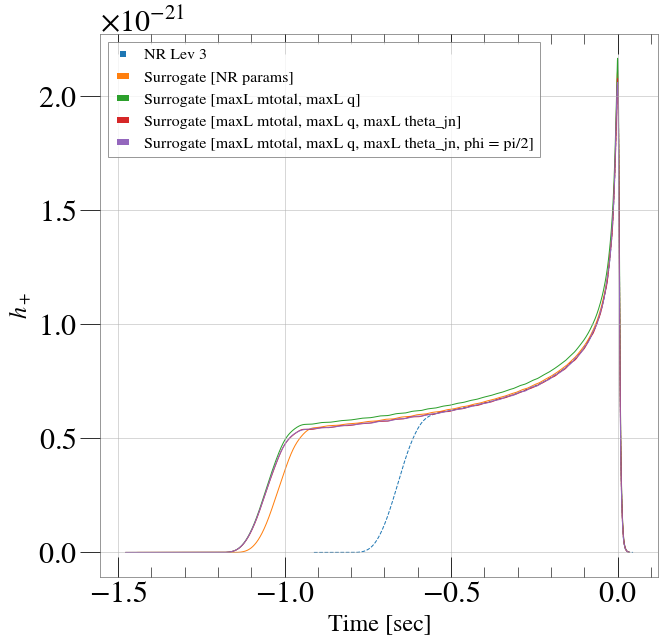

In [165]:
maxL_mass = 69.6909312833783
maxL_q = 1.0 / 0.975036137657211
maxL_dist = 243.9482603222831
maxL_theta_jn = 0.2803735304428691
maxL_phi = pi/2


plt.figure(figsize=(10,10))

# t, hp, hc, amp = ReadExtrapolatedModes('Waveforms/Lev1/dCS_Strain_0p0.h5', \
#                                                 mass_msun, dist_kpc, theta, phi, \
#                                                 dt, interpolate = True)

# plt.plot(t + 2e-4, amp, '--', label='NR Lev 1', lw = 1.0)


t, hp, hc, amp = ReadExtrapolatedModes('Waveforms/Lev2/dCS_Strain_0p0.h5', \
                                                mass_msun, dist_kpc, theta, phi, \
                                                dt, interpolate = True)

#plt.plot(t, hp, 'o', label='NR', lw = 1.0, markersize=2)


t, hp, hc, amp = ReadExtrapolatedModes('Waveforms/Lev3/dCS_Strain_0p0.h5', \
                                                mass_msun, dist_kpc, theta, phi, \
                                                dt, interpolate = True)

plt.plot(t + 2e-4, amp, '--', label='NR Lev 3', lw = 1.0)


## Surrogates

ts, hps, hcs, amps = EvaluateSurrogate(q, chiA, chiB, mass, dist_mpc, f_low, theta, phi, dt, \
                                                   surrogate_projection=True)

plt.plot(SubtractPeakTime(ts, amps), amps, '-', label='Surrogate [NR params]', lw = 1.0)



# ts, hps, hcs, amps = EvaluateSurrogate(q, chiA, chiB, maxL_mass, dist_mpc, f_low, theta, phi, dt, \
#                                                   surrogate_projection=True)

# plt.plot(SubtractPeakTime(ts, hps), hps, '-', label='Surrogate [maxL mtotal]', lw = 1.0)


ts, hps, hcs, amps = EvaluateSurrogate(maxL_q, chiA, chiB, maxL_mass, dist_mpc, f_low, theta, phi, dt, \
                                                 surrogate_projection=True)

plt.plot(SubtractPeakTime(ts, amps), amps, '-', label='Surrogate [maxL mtotal, maxL q]', lw = 1.0)



ts, hps, hcs, amps = EvaluateSurrogate(maxL_q, chiA, chiB, maxL_mass, dist_mpc, f_low, maxL_theta_jn, phi, dt, \
                                                  surrogate_projection=True)

plt.plot(SubtractPeakTime(ts, amps), amps, '-', label='Surrogate [maxL mtotal, maxL q, maxL theta_jn]', lw = 1.0)


ts, hps, hcs, amps = EvaluateSurrogate(maxL_q, chiA, chiB, maxL_mass, dist_mpc, f_low, maxL_theta_jn, maxL_phi, dt, \
                                                  surrogate_projection=True)

plt.plot(SubtractPeakTime(ts, amps), amps, '-', label='Surrogate [maxL mtotal, maxL q, maxL theta_jn, phi = pi/2]', lw = 1.0)



#ts, hps, hcs, amps = EvaluateSurrogate(maxL_q, chiA, chiB, maxL_mass, maxL_dist, f_low, theta, phi, dt, \
#                                                  surrogate_projection=True)


#plt.plot(ts, hps, '-', label='Surrogate [maxL mtotal, maxL q, maxL dist]', lw = 1.0)


#plt.yscale('log')



plt.xlabel('Time [sec]')
#plt.ylabel(r'$\sqrt{h_+^2 + h_\times^2}$')
plt.ylabel(r'$h_+$')

#plt.xlim(-0.04, 0.02)

plt.legend(fontsize=16)

plt.show()



### Plot the frame files

#### Max comparison

1126259458.0 s 1126259465.9995117 s


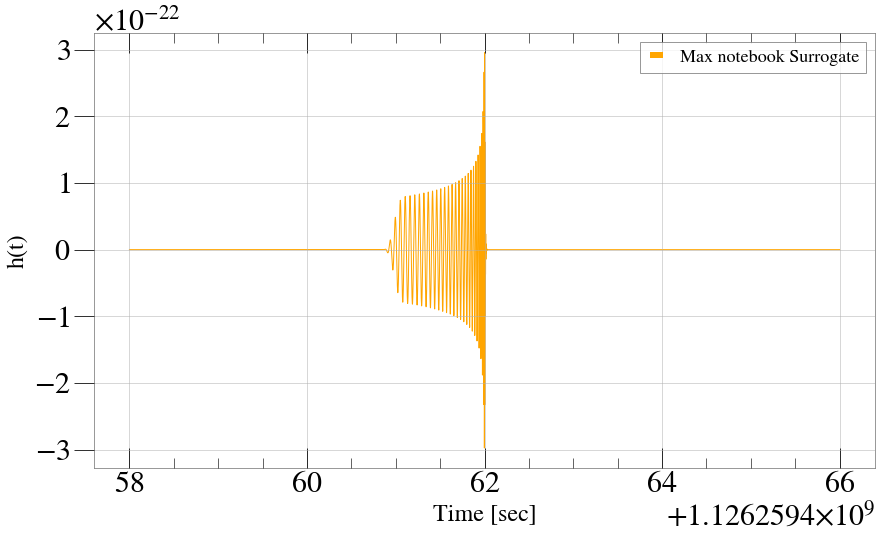

In [40]:
plt.figure(figsize=(14, 8))

sH = TimeSeries.read(source = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/Surrogate_Frames/Frames_EqualMassNonSpinning/H1.gwf', \
                     channel="H1:LDAS_STRAIN")
tH = sH.times
#sL = TimeSeries.read(source = 'L-L1_NONOISE-1126259334-256.gwf', channel="L1:INJ_STRAIN")
#tL = sL.times

plt.plot(np.array(tH), sH, '-', label='Max notebook Surrogate', color='orange', lw=1.0)
print(min(tH), max(tH))

# sHP = TimeSeries.read(source = 'H-H1_Phenom-1126259334-256.gwf', channel="H1:INJ_STRAIN")
# tHP = sHP.times
# sLP = TimeSeries.read(source = 'L-L1_Phenom-1126259334-256.gwf', channel="L1:INJ_STRAIN")
# tLP = sLP.times

#plt.plot(np.array(tHP), sHP, '-', label='Max notebook IMRPhenomV2', lw=1.0)

# sHm = TimeSeries.read(source = 'Frames/Surrogate_GW150914/Surrogate_GW150914_mtotal_68.0_dist_400.0/H-H1_HOFT-1126259454-16.gwf', channel="H1:LDAS_STRAIN")
# tHm = sHm.times
# sLm = TimeSeries.read(source = 'Frames/Surrogate_GW150914/Surrogate_GW150914_mtotal_68.0_dist_400.0/L-L1_HOFT-1126259454-16.gwf', channel="L1:LDAS_STRAIN")
# tLm = sLm.times

#plt.plot(np.array(tHm) + 1.53e-2, sHm, '--', label='Surrogate GW150914 params', lw=1.0)


plt.xlabel('Time [sec]')
plt.legend()
plt.ylabel('h(t)')
#tt = 1126259462.4107006
#plt.xlim(tt - 0.55, tt -0.35)
        
#plt.tight_layout()
plt.show()

#### Plot frames files for dCS params

0.005239009857177734 s
14512
1126259462.0463867
0.005239009857177734 s
14512
1126259462.0463867
0.005239009857177734 s
14512
1126259462.0463867
0.005239009857177734 s
14510
1126259462.0463867


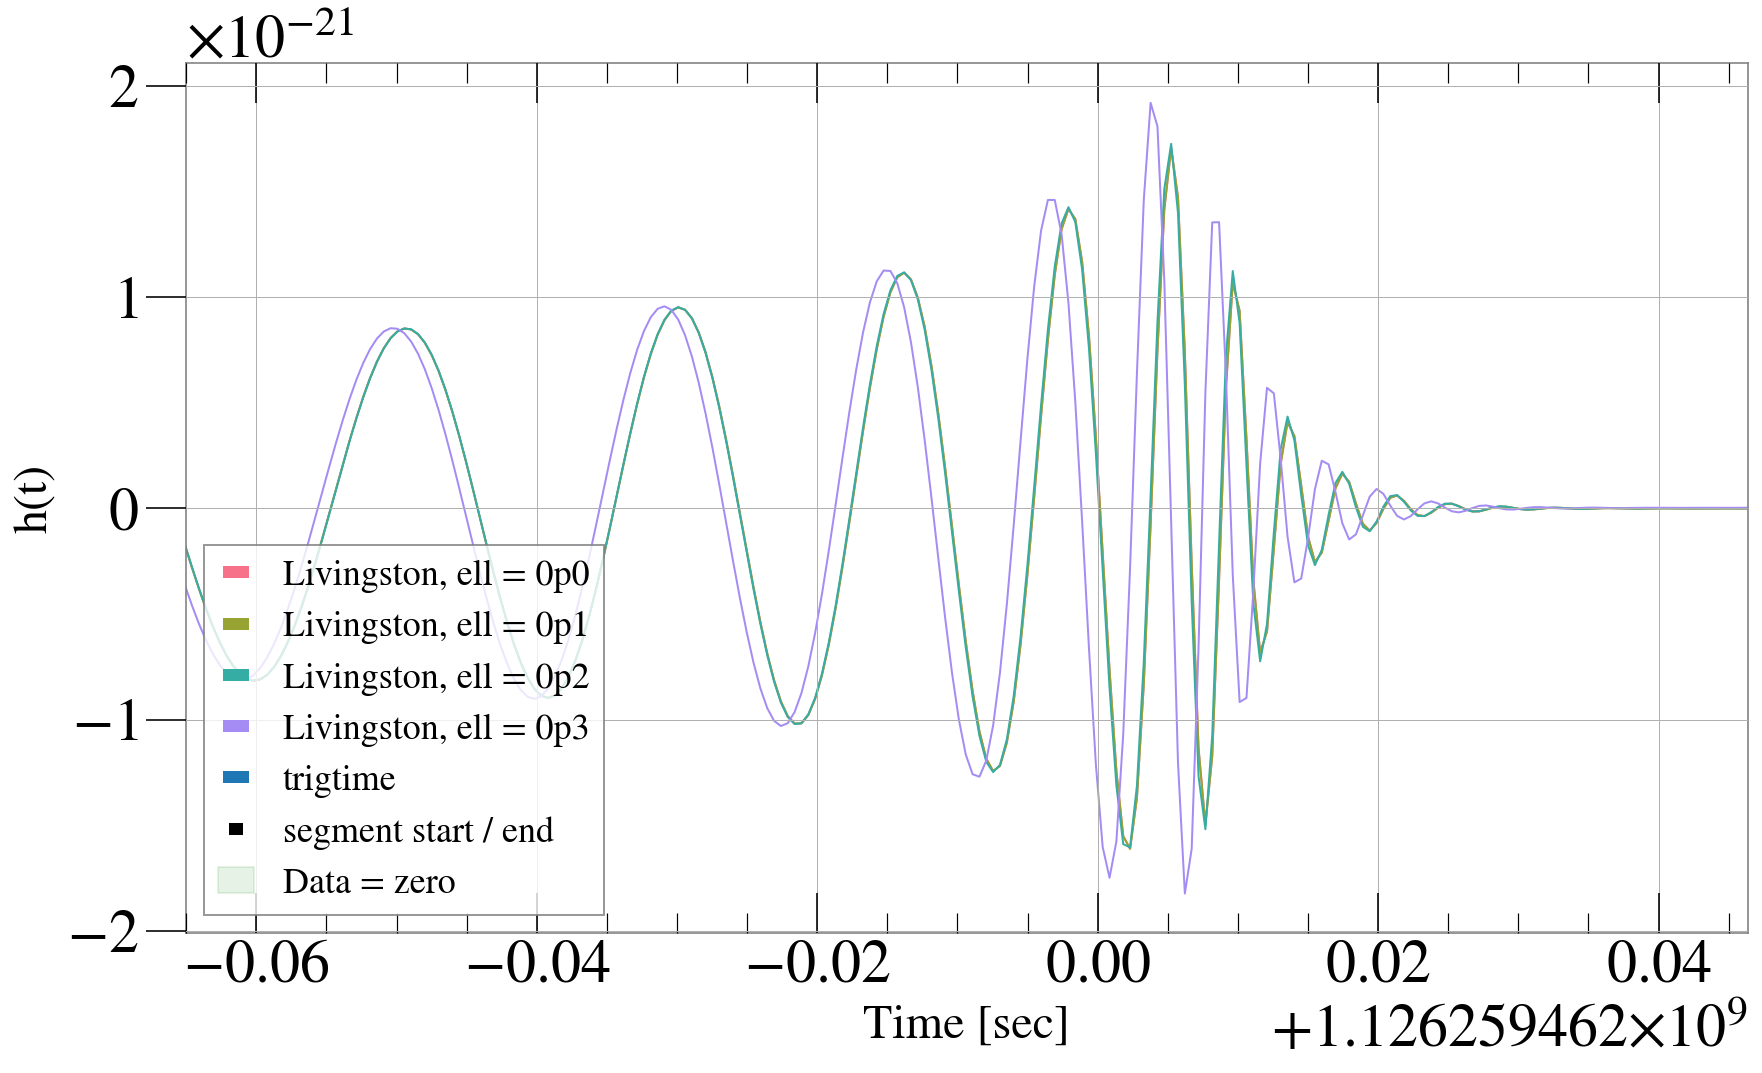

In [35]:
fig, ax = plt.subplots(figsize=(14, 8))

ells = ["0p0", "0p1", "0p2", "0p3"]
cs = sns.color_palette('husl', n_colors=len(ells))
for ell, color in zip(ells, cs):
    my_dir = "dCS_" + ell


    ## Livingston comes after hanford in this case
    sH = TimeSeries.read(source = '/home/maria.okounkova/BeyondGRAnalysis/Frames/'+my_dir+'/'+my_dir+'_mtotal_68_dist_400/H-H1_HOFT-1126259454-16.gwf', channel="H1:LDAS_STRAIN")
    tH = sH.times

    sL = TimeSeries.read(source = '/home/maria.okounkova/BeyondGRAnalysis/Frames/'+my_dir+'/'+my_dir+'_mtotal_68_dist_400/L-L1_HOFT-1126259454-16.gwf', channel="L1:LDAS_STRAIN")
    tL = sL.times
    
    ## Livingston comes after Hanford
    print(tL[-1] - tH[-1])
    
    ## Find where the data stops / starts being zero
    aa = np.array(np.where(sH == 0)[0])
    bb = aa[1:] - aa[:-1]
    start_index = np.where(bb != 1)[0][0]
    start = tH[start_index].value
    print(start_index)
    
    stop_index = 16479
    stop = tH[stop_index].value
    print(stop)
    #plt.plot(np.array(tH), sH, label='Hanford, ell = ' + ell, lw=1.0, color=color)
    plt.plot(np.array(tL), sL, '-', label='Livingston, ell = ' + ell, lw=1.0, color=color)

## Plot the trigtime for bayeswave
plt.axvspan(tH[0].value, start, label='Data = zero', color='green', alpha=0.1)
plt.axvspan(stop, tH[-1].value, color='green', alpha=0.1)
plt.axvline(1126259462.4107006, label='trigtime')
plt.axvline(1126259456.4107006, ls = '--', label='segment start / end', color='black')
plt.axvline(1126259456.4107006 + 8.0, ls = '--', color='black')
plt.xlabel('Time [sec]')
plt.xlim(start + 0.85, stop)
plt.legend(loc='lower left')
plt.ylabel('h(t)')
#tt = 1126259462.4107006
#plt.xlim(tt - 1.4, tt -0.2)
#plt.xlim(tt - 0.5, tt -0.37)      I 
# plt.tight_layout()
plt.show()

### Resolution analysis

the distance is 400.0


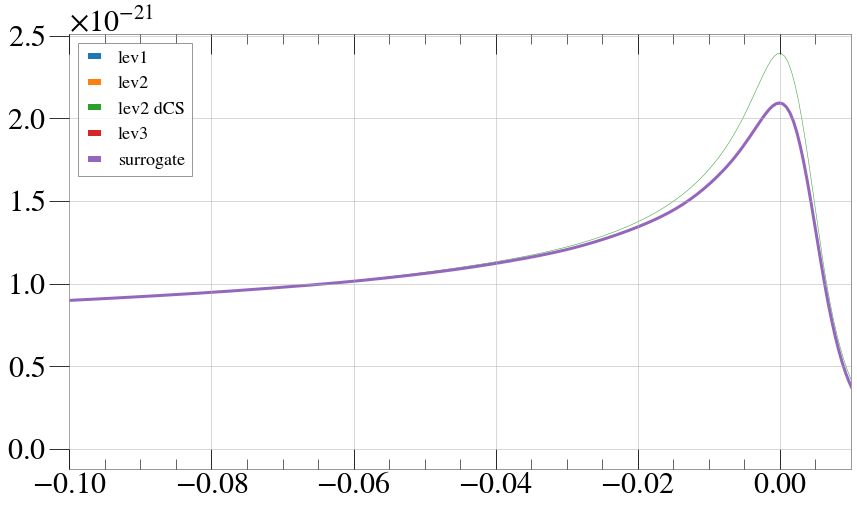

In [342]:
plt.figure(figsize=(14, 8))

def plot_resolution(p, label):
    time, h_plus, h_cross, amp = ReadExtrapolatedModes(p, mass_msun, dist_kpc, theta, phi, \
                                                     dt, interpolate = True)
    
    plt.plot(time, amp, label = label, lw = 0.5)
    
plot_resolution('Waveforms/Lev1/dCS_Strain_0p0.h5', 'lev1')
plot_resolution('Waveforms/Lev2/dCS_Strain_0p0.h5', 'lev2')
plot_resolution('Waveforms/Lev2/dCS_Strain_0p3.h5', 'lev2 dCS')
plot_resolution('Waveforms/Lev3/dCS_Strain_0p0.h5', 'lev3')


time_sur, h_plus_sur, h_cross_sur, amp_sur = EvaluateSurrogate(q, chiA, chiB, mass, dist_mpc, f_low, theta, phi, dt, \
                                                   surrogate_projection=True)
plt.plot(time_sur, amp_sur, label='surrogate')
    

plt.xlim(-0.1, 0.01)
plt.legend()
plt.show()